<a href="https://colab.research.google.com/github/jamespaultg/XAI_workshop/blob/master/Explainable_AI_Shap_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable AI workshop
# 0) Check setup for the Explainable AI workshop

Copy the contents of the github repo 'XAI_workshop' to the folder 'XAI_workshop'.
This will copy the data and the notebooks that we will use during the worksop

In [ ]:
!rm -r XAI_workshop
!git clone https://github.com/jamespaultg/XAI_workshop/

Cloning into 'XAI_workshop'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [ ]:
!pip install lime -q
!pip install shap -q


## 1) Load required libraries and data

In [ ]:
# Load required libraries

import lime
import lime.lime_tabular

import pandas as pd
import numpy as np
import statsmodels.api as sm

# For converting textual categories to integer labels 
from sklearn.preprocessing import LabelEncoder#
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV # for creating train test split
from sklearn.metrics import accuracy_score, classification_report
#from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve, auc, make_scorer, confusion_matrix, f1_score, fbeta_score, classification_report

# Our algorithms, by from the easiest to the hardest to intepret.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

import lightgbm as lgb


print('libraries loaded')

libraries loaded


In [ ]:
# Reading the titanic data
df_titanic = pd.read_csv('XAI_workshop/data/titanic.csv')
assert len(df_titanic) == 891, 'There is an error. Please email james gnanasekaran with the details of the error message you get'
df_titanic.head()


PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

# 2) Data preparation


In [ ]:
df_titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
# data preparation
df_titanic.fillna(0,inplace=True)

# label encoding textual data
le = LabelEncoder()
df_titanic['Sex_le'] = le.fit_transform(df_titanic['Sex'])

features = ["PassengerId", "Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_le"]

preprocessor = ColumnTransformer([("numerical", "passthrough", features)])

X = df_titanic[features]
y = df_titanic['Survived']

# using train test split to create validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, stratify = y)

**!Question general 1!** What is the percentage of people in the data surviving?

**Answer**: 38.4%

In [ ]:
y.mean()

0.3838383838383838

# 3) Creating pipelines

In [ ]:
# Logistic Regression
lr_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42))])

# Random Forest
rf_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", RandomForestClassifier(class_weight="balanced", n_estimators=100, n_jobs=-1))])

# XGBoost
xgb_model = Pipeline([("preprocessor", preprocessor), 
                      # Add a scale_pos_weight to make it balanced
                      ("model", XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))])

In [ ]:
# Logistic Regression
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7686567164179104
              precision    recall  f1-score   support

           0       0.83      0.78      0.81       165
           1       0.68      0.75      0.71       103

    accuracy                           0.77       268
   macro avg       0.76      0.76      0.76       268
weighted avg       0.77      0.77      0.77       268



In [ ]:
# Random Forest
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7910447761194029
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       165
           1       0.76      0.67      0.71       103

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.79      0.79      0.79       268



In [ ]:
# XG boost

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7947761194029851
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       165
           1       0.82      0.59      0.69       103

    accuracy                           0.79       268
   macro avg       0.80      0.76      0.77       268
weighted avg       0.80      0.79      0.79       268



**!Question general 2!** The classification reports provide a lot of numbers, but what do they mean? What is the difference between precision and recall? And what could be a reason that both models show better f1-scores for group 0 than 1? 

**Answer**: F1-score is the mean of precision and recall. Precision is how much of the identified are identified correctly and recall is how much of all the support is identified correctly. An analogy David likes is about the different sizes of fishnets and different levels of fishes in the water. Precision is high when the net is small and the number of fishes is large. Recall is high when the net is huge and the number of fishes is low. There are more "0" observations than "1" observations, so precision specifically will be higher for the "0" group (precision/recall both higher if the threshold value is adjusted).

# 4) Lime

Lime (Local Interpretable Model-Agnostic Explanations) is setup by following three steps:

1. Create a new explainer
  - my expaliner = Explainer()

2. Select an observation and create an explanation for it
  - observation = np.array([...]) -> note that this is not a pandas dataframe as used in the scikit pipelines
  - my_explanation = explainer.explain_instance(observation, predict_function)

3. Use methods on explantion to visaulise results
  - my_explantion.show_in_notebook()

In [ ]:
from lime.lime_tabular import LimeTabularExplainer


explainer = LimeTabularExplainer(X_train.values,
                                 mode = "classification",
                                 feature_names = X_train.columns.values.tolist(),
                                 discretize_continuous = True,
                                 random_state = 42)

In [ ]:
## Explanation for the different models
observation_to_explain = 23

observation = X_test.iloc[[observation_to_explain], :].values[0]
observation

array([322.    ,   3.    ,  27.    ,   0.    ,   0.    ,   7.8958,
         1.    ])

In [ ]:
# Let write a custom predict_proba functions for our models:
from functools import partial

def custom_predict_proba(X, model):
    X_str = pd.DataFrame(X, columns = X_train.columns)
    return model.predict_proba(X_str)

lr_predict_proba = partial(custom_predict_proba, model=lr_model)
rf_predict_proba = partial(custom_predict_proba, model=rf_model)
xgb_predict_proba = partial(custom_predict_proba, model=xgb_model)

In [ ]:
## logistic regression
j=10
explanation = explainer.explain_instance(X_test.values[j], lr_predict_proba, num_features=5)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.local_exp)
print(explanation.score)

{1: [(6, 0.49034887802201316), (1, -0.18151843764780265), (2, 0.07658544360108531), (3, 0.061125318861727375), (5, -0.05549579599629469)]}
0.9048381198402968


## There are three parts to the explanation :
- Left most part gives the prediction probabilities for class 0 and class 1.
- Middle part gives the 5 most important features. As it is an example of binary class we are looking at 2 colours. Attributes having orange colour support the class 1 and those with colour blue support class 0. Sex_le ≤0 means when this feature’s value satisfy this criteria it support class 0. Float point number on the horizontal bars represent the relative importance of these features.
- Right most part follows the same colour coding as the left and the middle part. It contains the actual values of for the top 5 variables.

In [ ]:
## XG-boost 

explanation = explainer.explain_instance(observation, xgb_predict_proba, num_features=5)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.48383098646554834


**!Question LIME 1!** After examining a few of the observations in the test set, which variables are typically the main drivers behind the different models?  

**ANSWER**: Sex is the most important variable (knowing the titanic set other good variables are passenger names (for example sirs and nobility have higher change of surviving)

**!Question LIME 2!** How is Lime different from more general feature importance methods? I.e. when would you use Lime and when would you use feature importance methods?

**ANSWER**: Feature importance is on a global level -> LIME is local

**!Question LIME 3!**
Why is it necessary to provide the Explainer with the entire table X_train? What is this table used for by the Explainer?

**ANSWER**: LIME uses X_train to create the underlying distribution on the local level

**!Question LIME 4!** Why can't we use the normal predict_proba function? And do we have to use the custom_predict_proba function? 

**ANSWER**: This is a difference between pandas dataframe (for the pipeline) and a numpy array (for LIME)

**!Question LIME 5!** What does the explanation.score depict. And why is it not suprising for the score to be higher for the logistic regression model compared to the XG-boost model?

**ANSWER**: Score is the $R^2$ of the underlying local linear regression that LIME creates. It measures how well on a local level the model can be approximated by a linear regression. LIME becomes less reliable if this number is low, because the model can’t be captured correctly by a linear model on a local level.

**EXTRA HARD QUESTION** To start of easy we removed all the catagorical variables from the data, but Lime is able to interpret catagorical variables (as can be seen in the Explainer() documentation). Adjust the whole code such that catagorical variable are taken into account. Start by using the OneHotEncoder  instead of the LabelEncoder.

# 5) SHAP(ley)

SHAP (SHapley Additive Explanations) is a package that uses the concept of Shapley values. The values calculated are not (always) the exact Shapley-values, as the problem of finding these values is 'NP-hard'. That's a fancy mathematical way of saying that it costs a buttload of time to calculate all values. Instead, the SHAP package approximates the Shapley-values in an efficient manner (see https://christophm.github.io/interpretable-ml-book/shap.html#definition for more info). 

The procedure we follow is rather similar to what we saw earlier with LIME:
- Create a new explainer
- Select an observation and create an explanation for it
- Use methods on explanation to visualise results

Let's start with the logistic regression as model (lr_model).

**Reminder: all models are predicting the probability of *survival* (1 = survival, 0 = death)**

In [ ]:
# Import packages
import shap 

# Create helper function logistic regression model
f_lr = lambda x: lr_model.predict_proba(x)[:,1]

# Create mask (we don't know that this means, but it works)
background_x_test = shap.maskers.Independent(X_test, max_samples=1000)

# create explainer
explainer_lr = shap.Explainer(f_lr, background_x_test)

# get shapley values
shap_values = explainer_lr(X_test)

# Have a look at shap_values
shap_values[1:5, ]


.values =
array([[ 6.94063573e-03, -8.89826951e-02,  8.21495999e-03,
         2.29550401e-02,  2.32881768e-03, -3.67066220e-02,
        -1.81896676e-01],
       [ 1.43505373e-04, -9.09946507e-02,  5.47308857e-02,
         2.38421950e-02,  2.40783593e-03, -3.75124072e-02,
        -1.81334597e-01],
       [ 2.18619137e-02, -8.86498078e-02, -1.06537065e-02,
         2.28370809e-02,  2.31773307e-03, -3.78078091e-02,
        -1.81712984e-01],
       [-6.88987276e-03, -8.33905182e-02, -4.92503152e-02,
         2.11884162e-02,  2.16171488e-03, -3.47876099e-02,
        -1.78735807e-01]])

.base_values =
array([0.4683704, 0.4683704, 0.4683704, 0.4683704])

.data =
array([[567.    ,   3.    ,  19.    ,   0.    ,   0.    ,   7.8958,
          1.    ],
       [460.    ,   3.    ,   0.    ,   0.    ,   0.    ,   7.75  ,
          1.    ],
       [805.    ,   3.    ,  27.    ,   0.    ,   0.    ,   6.975 ,
          1.    ],
       [339.    ,   3.    ,  45.    ,   0.    ,   0.    ,   8.05  ,
       

**!Question_SHAP_1!**: The number .468 is the same for each row. It's the 'base_value'. Can you say think of what it means in statistical terms?

In [ ]:
# Let's pick out a specific observation, ans see what that's like
observation_to_explain = 23
X_test.iloc[observation_to_explain, ]

PassengerId    322.0000
Pclass           3.0000
Age             27.0000
SibSp            0.0000
Parch            0.0000
Fare             7.8958
Sex_le           1.0000
Name: 321, dtype: float64

In [ ]:
# Now let's look at what the SHAP values for this observation are like
sv = shap_values[observation_to_explain, ]
sv


.values =
array([-0.00830568, -0.08660839, -0.01028359,  0.02214   ,  0.00225287,
       -0.03597439, -0.18115323])

.base_values =
0.46837040012922837

.data =
array([322.    ,   3.    ,  27.    ,   0.    ,   0.    ,   7.8958,
         1.    ])

**!QUESTION_SHAP_2!** Can you think of what the 'values' mean here? Use sv in the code chunk below to calculate what the model predicts as probability for this row. What appears to be the main driver for the model outcome?


In [ ]:
# Your formula here

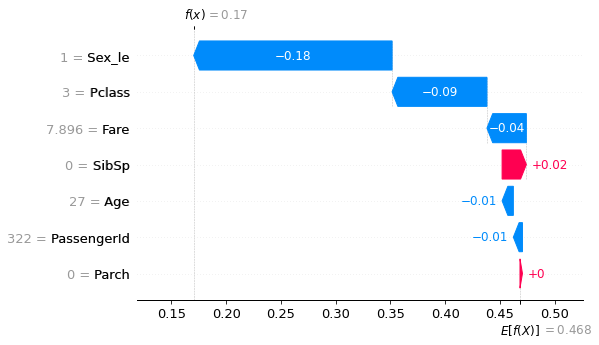

In [ ]:
# Now for some fancy graphs! 
# Use the visualization that is contained in the SHAP package
shap.plots.waterfall(shap_values[observation_to_explain])

Exact explainer: 269it [01:24,  3.20it/s]


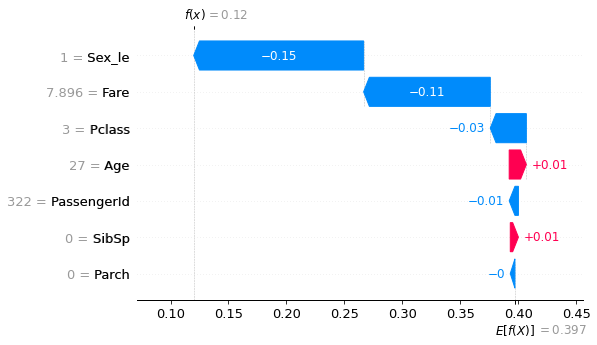

In [ ]:
# Let's repeat the process for the other models: random forest
# Note that we're using the exact same code as previously used
f_rf = lambda x: rf_model.predict_proba(x)[:, 1]
explainer_rf = shap.Explainer(f_rf, background_x_test)
shap_values_rf = explainer_rf(X_test)
shap.plots.waterfall(shap_values_rf[observation_to_explain])


Exact explainer: 269it [00:13, 20.48it/s]                         


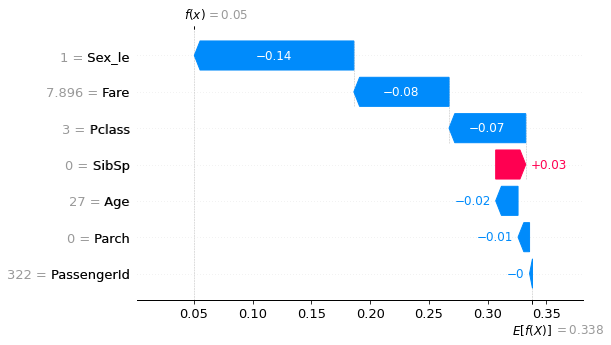

In [ ]:
# Let's repeat the process for the other models: XGB
# Note that we're using the exact same code as previously used
f_xgb = lambda x: xgb_model.predict_proba(x)[:,1]
explainer_xgb = shap.Explainer(f_xgb, background_x_test)
shap_values_xgb = explainer_xgb(X_test)
shap.plots.waterfall(shap_values_xgb[observation_to_explain])

**!QUESTION_SHAP_3!** Remarkably, the models give a different base_value for the probability of survival (.47 / .39 / .34). How can this be? 
Is this base value dependent on the observation/row, or is the same across all observations? 

**!QUESTION_SHAP_4!** All the models gave this poor kid a rather low probability of survival. Check if they were right. *N.B. remember what you learned from Laurie about loc/iloc stuff!!*

80


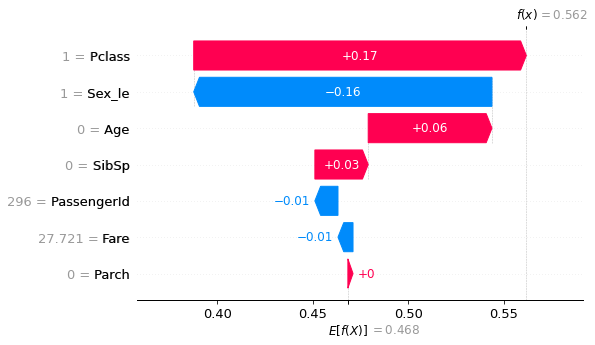

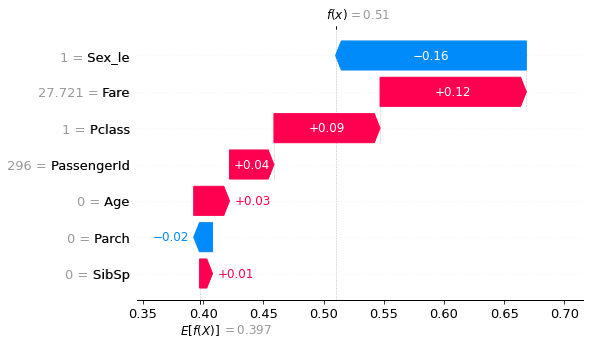

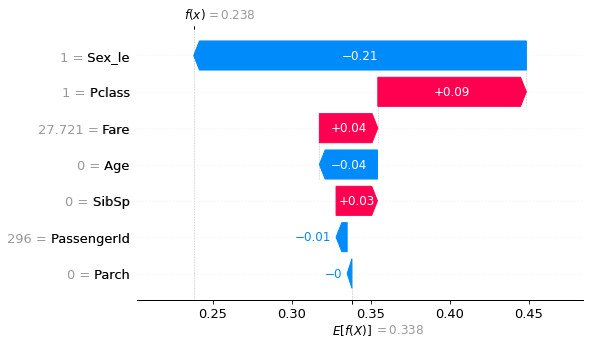

In [ ]:
# Enough with this kid. Let's look at some other passengers
# Run this a few times to look at a few rows/observations
import random
observation_to_explain2 = random.randrange(len(y_test))
shap_values_lr = shap_values
print(observation_to_explain2)
shap.plots.waterfall(shap_values_lr[observation_to_explain2])
shap.plots.waterfall(shap_values_rf[observation_to_explain2])
shap.plots.waterfall(shap_values_xgb[observation_to_explain2])

**!Question SHAP 5!** After examining a few of the observations in the test set, which variables are typically the main drivers behind the different models?

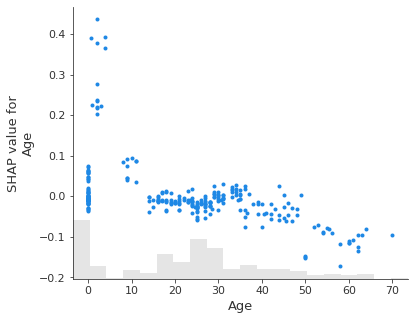

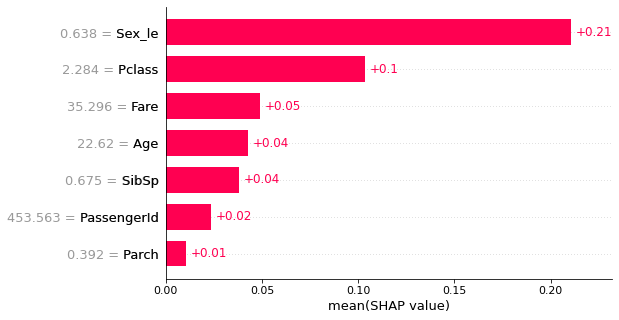

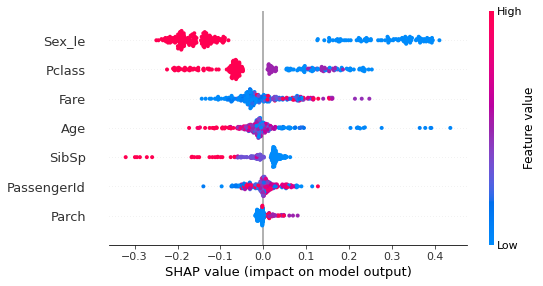

In [ ]:
# Now let's look at some other visualization techniques. These describe the model as a whole (instead of a single prediction)

# Look at the XGB-model for now (change this to look at the LR/RF model)
shap_values = shap_values_xgb

# Scatter plot of the partial effect of age
shap.plots.scatter(shap_values[:,"Age"])

# Bar plot of the mean absolute SHAP value
shap.plots.bar(shap_values)

# The'bee swarm' method that we saw earlier
shap.plots.beeswarm(shap_values)

**!Question SHAP 6!** (top graph) The SHAP value of Age seems to be lower the higher age is. Assume you see a (perfectly) straight line here (y = a + b * x). Would that imply a linear effect of age, or a quadratic effect?

**!Question SHAP 7!** (middle graph) Does the importance plot correspond with your answer to question 5? 

**!Question SHAP 8!** (bottom graph) Can you describe in words what the effect of Passenger class (Pclass) is on the probability of survival? E.g. *being in first class increases the probability of survival with @% according to the model*. Remember there are 3 classes (1, 2 and 3).

# 6) LIME and SHAP, a tale of two interpreters

Now that we've looked a these two models, let's try to make a comparison between the two. Below, we'll run LIME and SHAP on two observations, using the xgb model. Passenger number 322 is the poor fella we saw earlier with a 5% probability of survival. Passenger number 85, on the other hand, is a young lassie in second class with a 90% probability of survival. 

We're using the xbg model for both, so this 5% / 90% probability will be the same in both cases. What differs is the way the scores add up to this percentage. Remember that LIME and SHAP are explaining the exact same thing here. 

As a help in answering the questions, we have added all the partial effect together for a 'total effect', both for LIME and SHAP. You can see these below the figures.

In [ ]:
# LIME - observation 1
observation_to_explain = 23
observation_to_explain2 = 162
explanation = explainer.explain_instance(X_test.values[observation_to_explain], xgb_predict_proba)
explanation.show_in_notebook(show_table=True, show_all=False)

# Summing up all values leads to:
sum([e[1] for e in explanation.local_exp[1]])


-0.7042234420795591

In [ ]:
# LIME - observation 2
explanation2 = explainer.explain_instance(X_test.values[observation_to_explain2], xgb_predict_proba)
explanation2.show_in_notebook(show_table=True, show_all=False)

# Summing up all values leads to:
sum([e[1] for e in explanation2.local_exp[1]])

0.48818213572319274

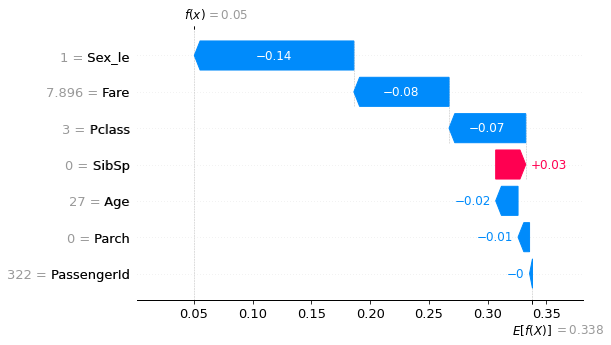

-0.287730085482793

In [ ]:
# SHAP - observation 1
shap.plots.waterfall(shap_values_xgb[observation_to_explain])
sum(shap_values_xgb[observation_to_explain].values)

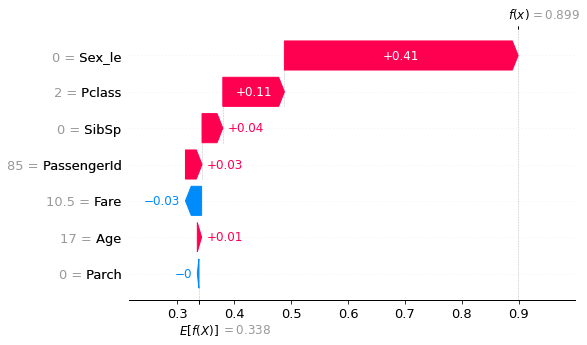

0.5609178181682062

In [ ]:
# SHAP - observation 2
shap.plots.waterfall(shap_values_xgb[observation_to_explain2])
sum(shap_values_xgb[observation_to_explain2].values)

**! Question SHAP_9 !**: What do you notice as the differences in the local interpretability? 

**! Question SHAP_10 !**: Based on what you've seen so far, which model would you be most likely to use to explain your 8*triple-layered hyperboosted neural network?

# 7) Where can you find more resources?

- Link to the original LIME paper 'Why should I trust you' - https://arxiv.org/abs/1602.04938
- Github link : https://github.com/marcotcr/lime

- https://www.oreilly.com/learning/introduction-to-local-interpretable-model-agnostic-explanations-lime
- https://blog.dominodatalab.com/shap-lime-python-libraries-part-2-using-shap-lime/
